# Quantization

The notebooks compare quantization types.

## One matrix

Taken from [MobileNet](https://github.com/onnx/models/tree/main/vision/classification/mobilenet).

In [1]:
import os
import urllib

url = "https://github.com/onnx/models/raw/main/vision/classification/mobilenet/model/mobilenetv2-12.onnx"
destination = "mobilenetv2-12.onnx"

if not os.path.exists(destination) or os.stat(destination).st_size < 10000:
    print(f"download {destination!r}")
    g = urllib.request.urlopen(url)
    with open(destination, "wb") as f:
        f.write(g.read())
    print("done")
else:
    print(f"already downloaded {destination!r}")
print(f"model size {os.stat(destination).st_size} bytes")

download 'mobilenetv2-12.onnx'
done
model size 13964571 bytes


In [2]:
from onnx import load

with open(destination, "rb") as f:
    onx = load(f)
    print(f"model size: {len(onx.SerializeToString())}")

model size: 13964571


Let's take one of the biggest matrix of coefficients:

In [3]:
initializers = []
for init in onx.graph.initializer:
    initializers.append((len(init.SerializeToString()), init.name, init))

initializers.sort()

for init in initializers[-5:]:
    print(init[:2])

(614421, '616')
(614421, '619')
(1228821, '625')
(1638421, '628')
(5120034, 'classifier.1.weight')


In [86]:
from onnx.numpy_helper import to_array

coef = to_array(initializers[-5][-1])
coef.shape, coef.dtype

((160, 960, 1, 1), dtype('float32'))

## Distributions

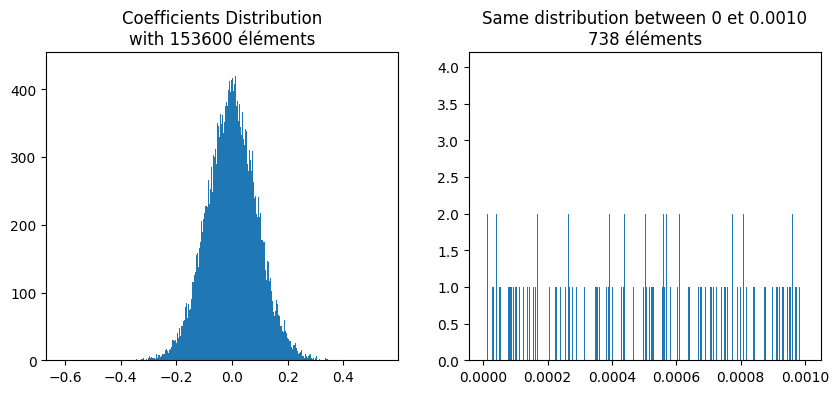

In [87]:
import matplotlib.pyplot as plt

cf = coef.ravel()
cf01 = cf[(cf >= 0) & (cf <= 0.001)]

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].hist(cf, bins=2048)
axs[0].set_title(
    f"Coefficients Distribution\nwith {cf.size} éléments"
)
axs[1].hist(cf01, bins=2048)
axs[1].set_title(f"Same distribution between 0 et {cf01.max():.4f}\n{cf01.size} éléments");

Distribution of float 8.

In [88]:
import numpy
from onnx.numpy_helper import float8e4m3_to_float32

float8 = [float8e4m3_to_float32(i) for i in range(0, 256)]
no_nan8 = [f for f in float8 if not numpy.isnan(f)]
len(no_nan8)

254

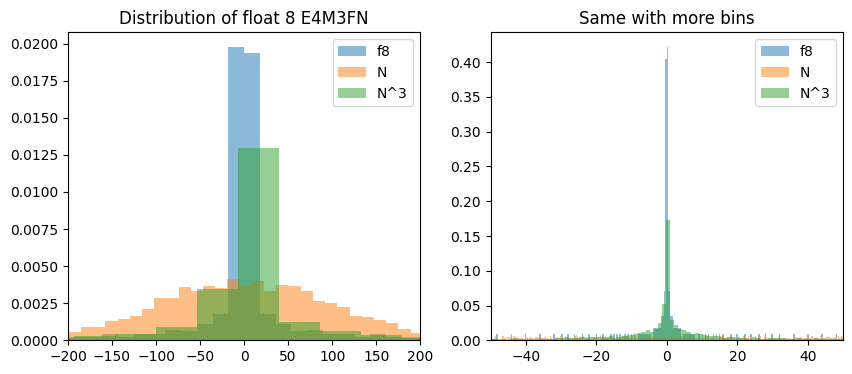

In [89]:
p = 3
gauss = numpy.random.normal(size=len(no_nan8) * 20)
scale1 = numpy.std(no_nan8) / numpy.std(gauss)
scalep = numpy.std(no_nan8) / numpy.std(gauss**p)


fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].hist(float8, bins=50, alpha=0.5, label="f8", density=True)
axs[0].hist(gauss * scale1, bins=50, alpha=0.5, label="N", density=True)
axs[0].hist(gauss**p * scalep, bins=50, alpha=0.5, label=f"N^{p}", density=True)
axs[0].set_xlim([-200, 200])
axs[0].set_title("Distribution of float 8 E4M3FN")
axs[0].legend()

axs[1].hist(float8, bins=2000, alpha=0.5, label="f8", density=True)
axs[1].hist(gauss * scale1, bins=2000, alpha=0.5, label="N", density=True)
axs[1].hist(gauss**p * scalep, bins=2000, alpha=0.5, label=f"N^{p}", density=True)
axs[1].set_xlim([-50, 50])
axs[1].set_title("Same with more bins")
axs[1].legend();

Curve `N^3` is gaussian at power 3. It was added to show that E4M3FN distribution is closer to $X^3$ than $X$ ($X$ is gaussian).

In [90]:
scale_f8p, zero_f8p = estimation_quantization_scale(coef, method="power")
scale_f8p, zero_f8p

(0.004002655570437662, -0.0)

## Scale estimation

Very basic:

* ratio of standard deviation for float 8
* quantile at 5% for uint 8

In [91]:
from onnx import TensorProto


def estimation_quantization_scale(
    coef: numpy.array, to: int = TensorProto.FLOAT8E4M3FN, method: str = "naive"
) -> tuple[float, float]:
    """
    Estimates the scale parameter for the quantization to float 8 assuming
    the distribution of the coefficients is gaussian.
    """
    if to == TensorProto.FLOAT8E4M3FN:
        float8 = [float8e4m3_to_float32(i) for i in range(0, 256)]
        quant_float = [f for f in float8 if not numpy.isnan(f)]
        if method == "naive":
            std_coef = numpy.std(coef.ravel())
            std_quant = numpy.std(numpy.array(quant_float, dtype=numpy.float32))
        elif method == "power":
            cr = coef.ravel()
            ca = numpy.abs(cr)
            std_coef = numpy.std(ca ** (1.0 / 3.0) * cr / ca)
            std_quant = numpy.std(numpy.array(quant_float, dtype=numpy.float32))
        else:
            raise ValueError(f"Unexpected quantization method {method!r}.")
        zero = 0.0
        scale = std_quant / std_coef
    elif to == TensorProto.UINT8:
        uint8 = [i for i in range(0, 256)]
        qu = numpy.quantile(coef.ravel(), [1 - 0.99999, 0.99999])
        scale = 255 / (qu[1] - qu[0])
        zero = qu[0] * scale
    else:
        raise ValueError(f"Unexpected quantization type for to={to}.")

    return 1.0 / scale, -zero


scale_f8, zero_f8 = estimation_quantization_scale(coef)
scale_f8, zero_f8

(0.0009081294882681465, -0.0)

In [92]:
scale_f8p, zero_f8p = estimation_quantization_scale(coef, method="power")
scale_f8p, zero_f8p

(0.004002655570437662, -0.0)

In [93]:
scale_u8, zero_u8 = estimation_quantization_scale(coef, to=TensorProto.UINT8)
scale_u8, zero_u8

(0.003963413028773201, 131.88381712385316)

## QDQ

Let's compare the square loss with two operators [QuantizeLinear](https://onnx.ai/onnx/operators/onnx__QuantizeLinear.html) + [DequantizeLinear](https://onnx.ai/onnx/operators/onnx__DequantizeLinear.html) ~ Identity.

In [94]:
from onnx.helper import (
    make_node,
    make_graph,
    make_model,
    make_tensor_value_info,
    make_operatorsetid,
    make_tensor,
)
from onnx.reference import ReferenceEvaluator

X = make_tensor_value_info("X", TensorProto.FLOAT, [None])
Scale = make_tensor_value_info("Scale", TensorProto.FLOAT, [1])
Y = make_tensor_value_info("Y", TensorProto.FLOAT, [None])

model_f8 = make_model(
    make_graph(
        [
            make_node(
                "Constant",
                [],
                ["Zero"],
                value=make_tensor("Zero", TensorProto.FLOAT8E4M3FN, [1], [0.0]),
            ),
            make_node("QuantizeLinear", ["X", "Scale", "Zero"], ["Q"], axis=0),
            make_node("DequantizeLinear", ["Q", "Scale"], ["Y"], axis=0),
        ],
        "quf8",
        [X, Scale],
        [Y],
    ),
    opset_imports=[make_operatorsetid("", 19)],
)

ref_f8 = ReferenceEvaluator(model_f8)
qu_f8 = ref_f8.run(
    None, {"X": coef.ravel(), "Scale": numpy.array([scale_f8], dtype=numpy.float32)}
)[0]
qu_f8

array([ 0.05448777,  0.06538533, -0.00590284, ...,  0.01997885,
        0.00590284,  0.21795107], dtype=float32)

In [95]:
qu_f8p = ref_f8.run(
    None, {"X": coef.ravel(), "Scale": numpy.array([scale_f8p], dtype=numpy.float32)}
)[0]
qu_f8p

array([ 0.05603718,  0.0720478 , -0.00600398, ...,  0.02001328,
        0.00550365,  0.20813808], dtype=float32)

In [96]:
model_u8 = make_model(
    make_graph(
        [
            make_node(
                "Constant",
                [],
                ["Zero"],
                value=make_tensor("Zero", TensorProto.UINT8, [1], [int(zero_u8)]),
            ),
            make_node("QuantizeLinear", ["X", "Scale", "Zero"], ["Q"], axis=0),
            make_node("DequantizeLinear", ["Q", "Scale", "Zero"], ["Y"], axis=0),
        ],
        "quu8",
        [X, Scale],
        [Y],
    ),
    opset_imports=[make_operatorsetid("", 19)],
)

ref_u8 = ReferenceEvaluator(model_u8)
qu_u8 = ref_u8.run(
    None, {"X": coef.ravel(), "Scale": numpy.array([scale_u8], dtype=numpy.float32)}
)[0]
qu_u8

array([ 0.05548779,  0.06737802, -0.00396341, ...,  0.01981707,
        0.00396341,  0.2140243 ], dtype=float32)

In [97]:
err_f8 = ((coef.ravel() - qu_f8) ** 2).sum() ** 0.5 / coef.size
err_f8p = ((coef.ravel() - qu_f8p) ** 2).sum() ** 0.5 / coef.size
err_u8 = ((coef.ravel() - qu_u8) ** 2).sum() ** 0.5 / coef.size
err_f8, err_f8p, err_u8

(6.497171816517831e-06, 6.141178007996629e-06, 3.0187591841210397e-06)

Plots

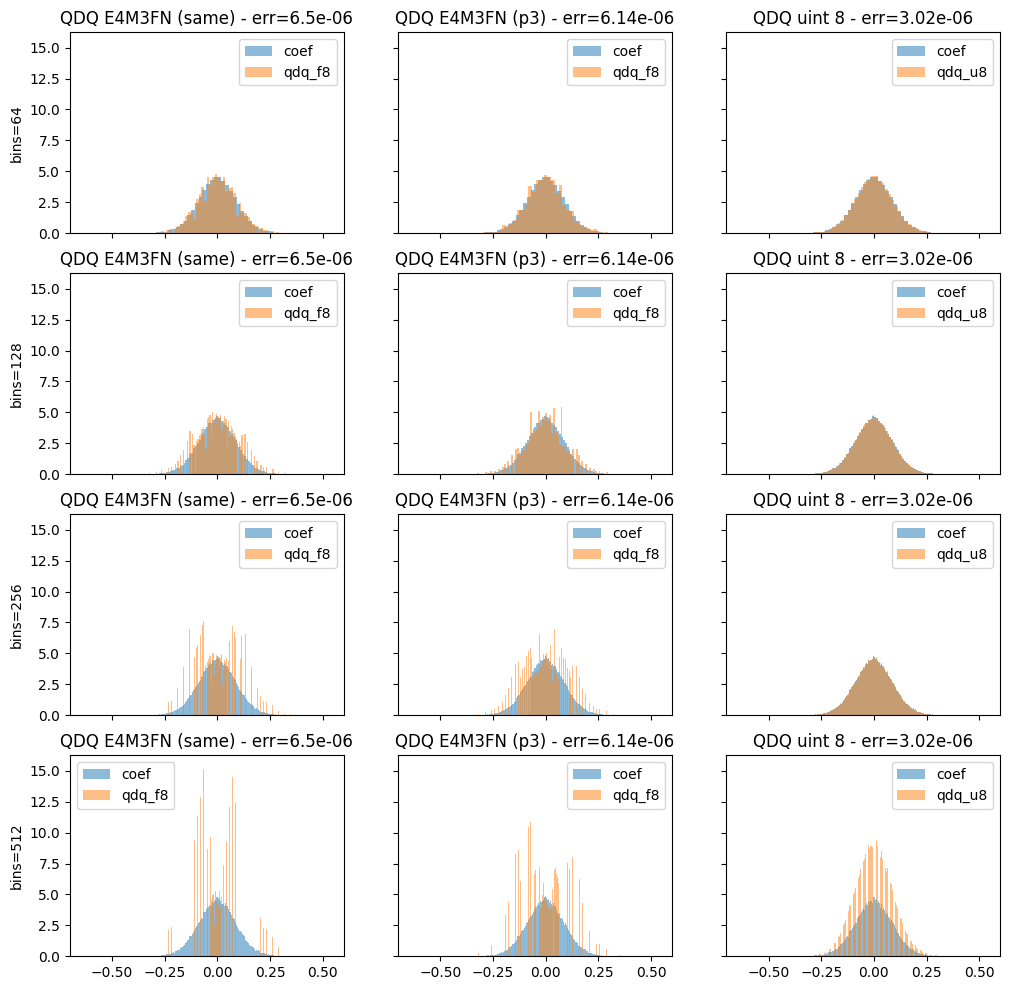

In [98]:
fig, axs = plt.subplots(4, 3, figsize=(12, 12), sharey=True, sharex=True)
for i, bins in [(0, 64), (1, 128), (2, 256), (3, 512)]:
    axs[i, 0].set_ylabel(f"bins={bins}")
    axs[i, 0].hist(coef.ravel(), bins=bins, density=True, label="coef", alpha=0.5)
    axs[i, 0].hist(qu_f8, bins=bins, alpha=0.5, label="qdq_f8", density=True)
    axs[i, 0].legend()
    axs[i, 0].set_title(f"QDQ E4M3FN (same) - err={err_f8:1.3g}")

    axs[i, 1].hist(coef.ravel(), bins=bins, density=True, label="coef", alpha=0.5)
    axs[i, 1].hist(qu_f8p, bins=bins, alpha=0.5, label="qdq_f8", density=True)
    axs[i, 1].legend()
    axs[i, 1].set_title(f"QDQ E4M3FN (p3) - err={err_f8p:1.3g}")

    axs[i, 2].hist(coef.ravel(), bins=bins, density=True, label="coef", alpha=0.5)
    axs[i, 2].hist(qu_u8, bins=bins, alpha=0.5, label="qdq_u8", density=True)
    axs[i, 2].legend()
    axs[i, 2].set_title(f"QDQ uint 8 - err={err_u8:1.3g}");

## Other scales

In [103]:
from pandas import DataFrame
from tqdm import tqdm

a = 0.00014669707383747942
h = 0.00014669707383747942 * 2

data = []
for scale in tqdm([a + h * i for i in range(10)]):
    got = ref_f8.run(
        None, {"X": coef.ravel(), "Scale": numpy.array([scale], dtype=numpy.float32)}
    )[0]
    err = ((coef.ravel() - got) ** 2).sum() ** 0.5 / coef.size
    obs = dict(scale=scale, err=err*1000)
    data.append(obs)
    
df = DataFrame(data)
df

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:08<00:00,  1.15it/s]


,scale,err
0,0.000147,0.122887
1,0.000440,0.025486
2,0.000733,0.007755
3,0.001027,0.006265
4,0.001320,0.006142
5,0.001614,0.006165
6,0.001907,0.006151
7,0.002200,0.006154
8,0.002494,0.006152
9,0.002787,0.006161


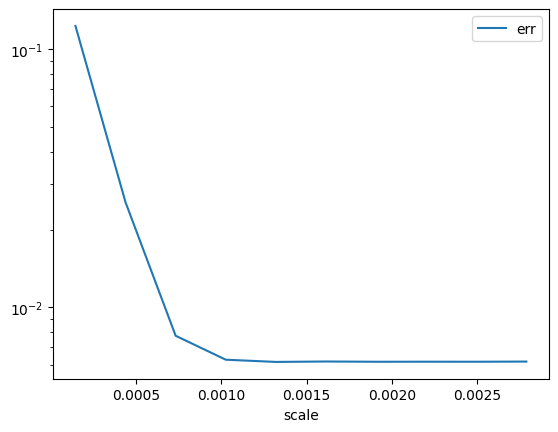

In [105]:
df.plot(x="scale", y="err", logy=True);